In [1]:
#these parameters drive the sea ice thickness estimation model
d_snow = 326.31 #mean of all SIPEX2 obs
#d_snow = 305.67 #mean of all EA obs
sd_dsnow = 10
sd_dice = 10
d_water = 1028
sd_dwater = 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

%matplotlib inline

In [3]:

# this function is the snow depth model. Parameters come from Steer et al (2016):
#Estimating snow depth from altimery for East Antarctic pack ice

def compute_zs(tf, s_i, tf_uncert):
    """
    Take in the total freeboard (tf, float array), slope and intercept for an empirical model
    of snow depth from elevation (s_i, tuple) and the total freeboard uncertainty
    (tf_uncert, float array)

    Return a snow depth, with an associated uncertainty.
    zs, uncert = compute_zs(tf, ([slope, intercept]), tf_uncert)
    """
    
    zs = (s_i[0] * tf) + s_i[1]

    zs_uncert = s_i[0] * tf_uncert

    return zs, zs_uncert


# next define the model for estimating ice thickness from total freeboard, snow depth
# and some density parameters:

def compute_zi(tf, zs, d_ice, d_water, d_snow, sd_tf, sd_zs, sd_dsnow, \
               sd_dice, sd_dwater):
    """"
    sea ice thickness from elevation, and propagation of uncertainties
    after Kwok, 2010; kwok and cunningham, 2008
    equations:
    4: sea ice thickness from elevation
    6: taylor series expansion of variance/covariance propagation using
    partial derivatives
    8, 9 and 10: partial derivatives used in the taylor series
    """
    zi = (d_water / (d_water-d_ice)) * tf - ((d_water-d_snow) / \
         (d_water - d_ice)) * zs

    zi_uncert = sd_tf**2 * (d_water / (d_water - d_ice))**2 + \
           sd_zs**2 * ((d_snow - d_water) / (d_water - d_ice))**2 + \
           sd_dsnow**2 * (zs / (d_water - d_ice))**2 + \
           sd_dice**2 * (tf /  (d_water - d_ice))**2 + \
           sd_dwater**2 * (((-d_ice * tf) + ((d_ice-d_snow) * zs)) / \
           (d_water - d_ice)**2)**2

    return zi, zi_uncert


#http://stackoverflow.com/questions/36031338/interpolate-z-values-in-a-3d-surface-starting-from-an-irregular-set-of-points

class Estimation():
    def __init__(self,datax,datay,dataz):
        self.x = datax
        self.y = datay
        self.v = dataz

    def estimate(self,x,y,using='ISD'):
        """
        Estimate point at coordinate x,y based on the input data for this
        class.#http://stackoverflow.com/questions/36031338/interpolate-z
        -values-in-a-3d-surface-starting-from-an-irregular-set-of-points

        """
        if using == 'ISD':
            return self._isd(x,y)

    def _isd(self,x,y):
        d = np.sqrt((x-self.x)**2+(y-self.y)**2)
        if d.min() > 0:
            v = np.sum(self.v*(1/d**2)/np.sum(1/d**2))
            return v
        else:
            return self.v[d.argmin()]

In [4]:
gtdrills = np.genfromtxt('/media/adam/data/is6_f11/insitu/icethickness_not_transect.txt', 
                         usecols=(0,1,2,3,4,5), skip_header=1, delimiter=',')

In [5]:
is6holes = np.genfromtxt('/media/adam/data/is6_f11/insitu/is6.csv', delimiter = ',')
is6zs = is6holes[:,4]
is6tf = is6holes[:,3] + is6holes[:,4]
is6fi = is6holes[:,3]
is6draft = is6holes[:,5]
nozero = np.where(is6draft == 0)
is6draft[nozero] = np.nan

In [6]:
## read in some pre-processed liDAR. This 2 million point bit already has ZI computed, but we ignore that for now
# and just get 3D point position, z uncertainty.
lidar = np.genfromtxt('/media/adam/data/is6_f11/python_zi/is6_f11_pass1_aa_nr2_522816_523019_c_zi.xyz')
#cut out a ship

In [7]:
ship_inds = np.where((lidar[:,1] >= -110.3) &
              (lidar[:,1] <= 2.3) &
              (lidar[:,2] >= -80.95) &
              (lidar[:,2] <= -29.26))

In [8]:
l1 = np.zeros_like(lidar[:,0])
l1[ship_inds] = 1
lidar = lidar[np.where(l1 <1),:]

In [9]:
lidar = np.squeeze(lidar)
lidar = lidar[1:,:]

In [10]:
#get some indices for LiDAR near the transect line
lidar_t = np.where((lidar[:,1] > -0.5) & (lidar[:,1] < 0.5) & (lidar[:,2] >= 0) & (lidar[:,2] <= 100))
lidar_t2 = np.where((lidar[:,1] > -2.5) & (lidar[:,1] < 2.5) & (lidar[:,2] >= -5) & (lidar[:,2] <= 105))

In [11]:
# get a subset of LiDAR obs inside the AUV grid
subset = lidar[(lidar[:,1] >= -150) & (lidar[:,1] <= 130) & (lidar[:,2] >= -30) & (lidar[:,2] <= 270) ]

# get lidar indices near the transect from the subset...
lidar_ts = np.where((subset[:,1] > -0.5) & (subset[:,1] < 0.5) & (subset[:,2] >= 0) & (subset[:,2] <= 100))

#get out some usefule bits of data
tf = subset[:,3] # total freeboard
tf_uncert = subset[:,4] # total freeboard uncertainty

In [12]:
#use our estimator to find transect properties?
t_li = Estimation(subset[lidar_ts,1],subset[lidar_ts,2],subset[lidar_ts,3])
this = np.arange(0,101,1)
that = np.zeros_like(this)
transect = np.column_stack((that,this))
t_li_tf = []
for hole in transect:
    elev_hole = t_li.estimate(hole[0], hole[1])
    t_li_tf.append(elev_hole)

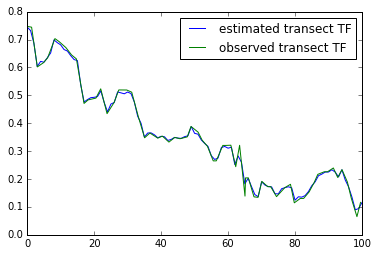

In [13]:
plt.plot(this, t_li_tf, label='estimated transect TF')
plt.plot(subset[lidar_ts[0],2], subset[lidar_ts[0],3], label = 'observed transect TF')
plt.legend(loc=0)


In [14]:
#get some AUV draft, pre trimmed
auv = np.genfromtxt('/media/adam/data/is6_f11/lidar_auv_analysis/auv_subset.txt')
auv_draft = auv[:,2]

In [15]:
# a quick function to make ice parameters from a range of density values
def build_dens(tf, zs, d_water, d_snow, tf_uncert, \
                    zs_uncert, sd_dsnow, sd_dice, sd_dwater,densities):
    d_table = []
    for d in densities:     
        zi, zi_uncert = compute_zi(tf, zs, d, d_water, d_snow, tf_uncert, \
                           zs_uncert, sd_dsnow, sd_dice, sd_dwater)
    
        d_table.append([d,np.mean(tf-(zs + zi)), np.median(tf-(zs + zi)), np.std(tf - (zs + zi)), np.mean(zi_uncert)])
    return np.array(d_table)

### first, make a canonical 'draft estimate'
using the all EA model, and density of 915.6 kg/m^3

In [77]:
s_i = ([0.701, -0.0012])
zs_, zs_uncert = compute_zs(tf, s_i, 0.1)

zi_s2snow, zi_uncert_s2snow = compute_zi(tf, zs_, 915.6, d_water, d_snow, tf_uncert, \
                           zs_uncert, sd_dsnow, sd_dice, sd_dwater)

df_s2snow = tf - (zi_s2snow + zs_)

densities = np.arange(800,940,0.2)
auv_mean_ = np.zeros_like(densities, dtype='float32')
auv_mean_[:] = np.nanmean(auv_draft)

d_table_ = []
d_table_ = build_dens(tf, zs_, d_water, d_snow, tf_uncert, \
                    zs_uncert, sd_dsnow, sd_dice, sd_dwater, densities)
mean_draft_ = -d_table_[:,1]

idx_ = np.argwhere(np.isclose(auv_mean,mean_draft_, atol=0.00259)).reshape(-1)
idx_ = idx_[0]


In [68]:

#for all the data
tf_a = lidar[:,3] # total freeboard
tf_uncert_a = lidar[:,4] # total freeboard uncertainty
zs_a, zs_uncert_a = compute_zs(tf_a, s_i, 0.1)

zi_s2snow_a, zi_uncert_s2snow_a = compute_zi(tf_a, zs_a, 915.6, d_water, d_snow, tf_uncert_a, \
                           zs_uncert, sd_dsnow, sd_dice, sd_dwater)

df_s2snow_a = tf_a - (zi_s2snow_a + zs_a)

### Next, using a single value for all snow
if we use the SIPEX2 mean from drill holes for IS6, what density do we need?

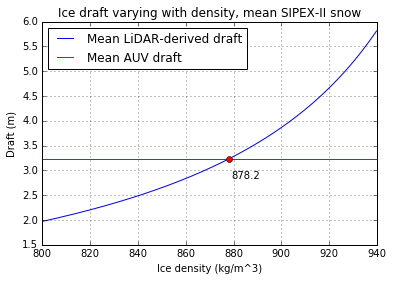

In [20]:
densities = np.arange(800,940,0.2)

#compute snow depth based on an empirical model
#s_i = ([0.701, -0.0012]) #model from all EA drill holes
#zs, zs_uncert = compute_zs(tf, s_i, tf_uncert)

#use mean SIPEX2 snow depth
zs_m = 0.27
zs_m_uncert = 0.05
d_table_m = []
d_table_m = build_dens(tf, zs_m, d_water, d_snow, tf_uncert, \
                    zs_m_uncert, sd_dsnow, sd_dice, sd_dwater, densities)
mean_draft_m = -d_table_m[:,1]

#plt.figure(figsize=(12/2.51,8/2.51))


plt.plot(d_table_m[:,0], mean_draft_m, label='Mean LiDAR-derived draft')

auv_mean = np.zeros_like(densities, dtype='float32')
auv_mean[:] = np.nanmean(auv_draft)

plt.plot(d_table_m[:,0], auv_mean, label='Mean AUV draft')

idx_m = np.argwhere(np.isclose(auv_mean,mean_draft_m, atol=0.0026)).reshape(-1)
idx_m = idx_m[0]
plt.plot(densities[idx_m], mean_draft_m[idx_m], 'ro')

plt.text(densities[idx_m]+1, mean_draft_m[idx_m]-0.4, str(densities[idx_m]))

plt.ylabel('Draft (m)')
plt.xlabel('Ice density (kg/m^3)')
plt.grid()
plt.legend(loc=0)
plt.title('Ice draft varying with density, mean SIPEX-II snow')

That's within observed ranges! Lets make some ice thickness and draft with these values

In [21]:
zi_is6msnow, zi_uncert_is6msnow = compute_zi(tf, 0.41, 878.2, d_water, d_snow, tf_uncert, \
                           zs_uncert, 0.05, sd_dice, sd_dwater)

df_is6msnow = tf - (zi_is6msnow + 0.27)

...to see how they stack up with other estimates

### For another example, if we use the SIPEX snow model, what do we get?

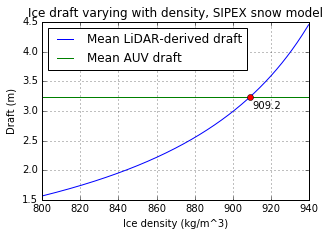

In [22]:

#use SIPEX snow model
s_i = ([0.62, 0.018])

#s_i = ([0.701, -0.0012]) #model from all EA drill holes

zs_sipex1, zs_sipex1_uncert = compute_zs(tf, s_i, 0.1)
d_table_s1 = []
d_table_s1 = build_dens(tf, zs_sipex1, d_water, d_snow, tf_uncert, \
                    zs_sipex1_uncert, sd_dsnow, sd_dice, sd_dwater, densities)
mean_draft_s1 = -d_table_s1[:,1]

plt.figure(figsize=(12/2.51,8/2.51))

plt.plot(d_table_s1[:,0], mean_draft_s1, label='Mean LiDAR-derived draft')

auv_mean = np.zeros_like(densities, dtype='float32')
auv_mean[:] = np.nanmean(auv_draft)


plt.plot(d_table_s1[:,0], auv_mean, label='Mean AUV draft')

idx_s1 = np.argwhere(np.isclose(auv_mean,mean_draft_s1, atol=0.003)).reshape(-1)
idx_s1 = idx_s1[0]
plt.plot(densities[idx_s1], mean_draft_s1[idx_s1], 'ro')

plt.text(densities[idx_s1]+1,mean_draft_s1[idx_s1]-0.2, str(densities[idx_s1]))

plt.ylabel('Draft (m)')
plt.xlabel('Ice density (kg/m^3)')
plt.grid()
plt.legend(loc=0)
plt.title('Ice draft varying with density, SIPEX snow model')

again, close to observed values. Lets make some drafts...

In [23]:
zi_sipex1, zi_uncert_sipex1 = compute_zi(tf, zs_sipex1, 909.2, d_water, d_snow, tf_uncert, \
                           zs_sipex1_uncert, 0.05, sd_dice, sd_dwater)

df_sipex1snow = tf - (zi_sipex1 + zs_sipex1)

## We know that snow is overestimated over rough ice, so lets try to reduce it's depth

In [24]:
#import our roughness proxy
rproxy = np.genfromtxt('/media/adam/data/is6_f11/python_zi/is6_f11_pass1_aa_nr2_522816_523019_crproxy.xyz',
                       skip_header=1)

In [25]:
#remove the ship
r_ship_inds = np.where((rproxy[:,1] >= -110.3) &
              (rproxy[:,1] <= 2.3) &
              (rproxy[:,2] >= -80.95) &
              (rproxy[:,2] <= -29.26))

rl1 = np.zeros_like(rproxy[:,0])
rl1[r_ship_inds] = 1

rproxy = rproxy[np.where(rl1 < 1),:]
rproxy = np.squeeze(rproxy)
rproxy = rproxy[1:,:]

In [26]:
#get our subset
rsubset = rproxy[(rproxy[:,1] >= -150) & (rproxy[:,1] <= 130) & (rproxy[:,2] >= -30) & (rproxy[:,2] <= 270) ]

In [27]:
np.mean(rsubset[:,5])

0.14894887252781819

In [28]:
subset_rough = np.where(rsubset[:,5] >= np.median(rsubset[:,5]))
subset_smooth = np.where(rsubset[:,5] < np.median(rsubset[:,5]))

In [29]:
np.median(rsubset[:,5])

0.11989

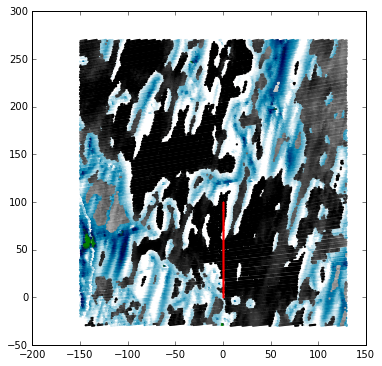

In [30]:
#have a look at rough and smooth bits
fig = plt.figure()
fig.set_size_inches(25/2.51, 15/2.51)

ax0 = fig.add_subplot(111)
ax0.scatter(rsubset[subset_rough,1], rsubset[subset_rough,2], c=np.ndarray.tolist(tf[subset_rough]),\
                cmap='ocean_r', lw=0, vmin=0.5, vmax=3, s=5)
#ax0.view_init(elev=50, azim=130)

ax0.scatter(rsubset[subset_smooth,1], rsubset[subset_smooth,2], c=np.ndarray.tolist(tf[subset_smooth]),\
                cmap='gray', lw=0, vmin=0.5, vmax=2, s=5)
ax0.set_aspect('equal')

plt.scatter(is6holes[:,0], is6holes[:,1], c='r', lw=0, s=3)

#ax1.view_init(elev=70, azim=300)
plt.savefig('roughsmooth_11m.png')

### OK, the transect is all on *smooth* ice
That is not super helpful for analysis, but tells us something about the nature of transects as a way to sample ice

In [31]:
np.mean(tf[subset_smooth])

0.60421115340752685

In [32]:
np.mean(tf[subset_rough])

0.83913601997090836

### Good news. Rough ice has a higher mean freeboard than smooth ice.
We would expect to capture ridges in the 'rough' set, so this is a nice confirmation

Now, we need to define a function which modifies snow depth. Using the following logic:
- toward the top of ridges, snow gets less deep
- near ridge bottoms, snow is likely to be deeper
- this likely only applies for freeboard > mean(freeboard)

we define:

In [33]:
def thinsnow2(tf, zs, inds):
    '''
    Function to modify snow depths on sea ice.
    Inputs are a set of total freeboards (tf), snow depths (zs)
    and indices (inds) of snow depths which are to be modified.
    
    For example:
    snow_mod = thinsnow(tf, zs, rough_ice)
    
    ...where 'rough_ice' is the result of some function such that:
    
    rough_ice = np.where(tf = rough)
    
    '''
    
    #make an array of proportions, fill it with 1.
    # this is used to scale snow depths.
    tf_pns = np.ones_like(tf)
    
    # find the mean total freeboard of the full set
    tf_mean = np.mean(tf)
    #...and the maximum total freeboard of the
    # subset to be modified
    tfmax = np.max(tf[inds])
    
    #looping through...
    for i in inds:
        #if total freeboard > mean(total freeboard)
        if tf[i] > tf_mean:
            #find the proportion of current freeboard to max
            # freeboard. If it is smaller than 1,
            # assign it to the 'proportions' array
            if (tf[i] / tfmax) < 1:
                tf_pns[i] = (tf[i] / tfmax)
            # if it equals 1,set proportions to 0
            elif (tf[i] / tfmax) == 1:
                 tf_pns[i] = 0 
        #otherwise, for freeboard  < mean(freeboard),
        # use the full input snow depth
        else:
            tf_pns[i] = 1
    
    #multiply snow depth by proportions array
    zs_ = zs * tf_pns
    
    #this means that:
    # - the tallest point in a freeboard set always
    # has snow depth = 0
    # - between the mean freeboard and tallest freeboard
    # snow depth is reduced as a function of total freeboard
    
    #an implication of doing this is that ice thickness will be
    # highly concentrated in tall ridges, keels will be really
    # deep. Also, 'smooth' ice will be thinner.
    
    #return bothsubsets
    return tf_pns, zs_

In [34]:
### check that the model works...

In [35]:
#xyz = np.abs(5*np.random.random(10))
xyz= np.array([1.5, 1, 0.5, 1, 1.5, 2, 1.5, 0.5, 1, 0.5])

max(xyz)
kjh = xyz-0.5

In [36]:
p, z_s = thinsnow2(xyz, 0.5, np.arange(0,10,1))

1.1000000000000001

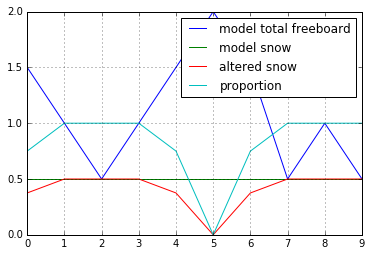

In [37]:
plt.plot(xyz, label = 'model total freeboard')
plt.plot(xyz-kjh, label='model snow')
plt.plot(z_s, label ='altered snow')
plt.plot(p, label = 'proportion')

plt.grid()
plt.legend(loc=0)
np.mean(xyz)

### this looks expected
- the tallest 'ice' has no snow
- snow below mean TF is left alone
- snow between mean and max TF is thinned as a function of TF

### now, lets apply it to our IS6 subset

In [38]:
#using our canonical, all_EA snow model snow...
#thin the snow
props_, zs_thinned = thinsnow2(tf, zs_, subset_rough[0])


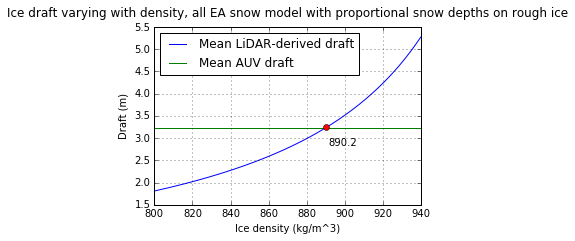

In [40]:
#find a density for the thinned snow
d_table_ts = []
d_table_ts = build_dens(tf, zs_thinned, d_water, d_snow, tf_uncert, \
                    zs_uncert, sd_dsnow, sd_dice, sd_dwater, densities)
mean_draft_ts = -d_table_ts[:,1]

plt.figure(figsize=(12/2.51,8/2.51))

plt.plot(d_table_ts[:,0], mean_draft_ts, label='Mean LiDAR-derived draft')



plt.plot(d_table_ts[:,0], auv_mean, label='Mean AUV draft')

idx_ts = np.argwhere(np.isclose(auv_mean,mean_draft_ts, atol=0.00259)).reshape(-1)
idx_ts = idx_ts[0]
plt.plot(densities[idx_ts], mean_draft_ts[idx_ts], 'ro')
plt.text(densities[idx_ts]+1, mean_draft_ts[idx_ts]-0.4, str(densities[idx_ts]))

plt.ylabel('Draft (m)')
plt.xlabel('Ice density (kg/m^3)')
plt.grid()
plt.legend(loc=0)
plt.title('Ice draft varying with density, all EA snow model with proportional snow depths on rough ice', y=1.03)

### Density here is 890.2. High for SIPEX 2, within observed ranges

In [41]:
#make some new ice using our new snow and density
zi_s2r_snow, zi_uncert_s2r_snow = compute_zi(tf, zs_thinned, 890.2, d_water, d_snow, tf_uncert, \
                           zs_uncert, sd_dsnow, sd_dice, sd_dwater)

df_s2r_snow = tf - (zi_s2r_snow + zs_thinned)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


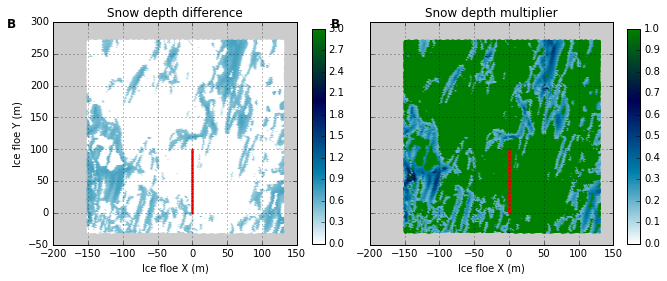

In [44]:
fig = plt.figure(figsize = ([22/2.51, 10/2.51]), dpi=300)

fig.add_subplot()

cmap0= plt.get_cmap('gist_earth_r')

ax0 = plt.subplot(1,2,1)
a0 = ax0.scatter(rsubset[:,1], rsubset[:,2], c= zs_-zs_thinned, cmap='ocean_r', lw=0, vmin=0, vmax=3, s=10)
cbaxes0= fig.add_axes([0.49, 0.14, 0.02, 0.75])
cb0 = plt.colorbar(a0, cax=cbaxes0, cmap=cmap0)
ax0.scatter(is6holes[:,0], is6holes[:,1], c='r', lw=0, s=3)

ax0.text(-0.17, 0.99,'B', ha='center', va='center', transform=ax0.transAxes, fontsize=12, weight='bold')

ax0.grid()
ax0.set_axis_bgcolor((0.8, 0.8, 0.8))
ax0.set_xlabel('Ice floe X (m)')
ax0.set_ylabel('Ice floe Y (m)')

ax0.set_title('Snow depth difference')

cmap1= plt.get_cmap('ocean_r')
subset_rough[0]
ax1 = plt.subplot(1,2,2)
a1 = ax1.scatter(rsubset[:,1], rsubset[:,2], c=props_, cmap='ocean_r', lw=0, vmin=0, vmax=1, s=10)
cbaxes1= fig.add_axes([0.99, 0.14, 0.02, 0.75])
cb1 = plt.colorbar(a1, cax=cbaxes1, cmap=cmap1)
ax1.scatter(is6holes[:,0], is6holes[:,1], c='r', lw=0, s=3)

ax1.text(-0.14, 0.99,'B', ha='center', va='center', transform=ax1.transAxes, fontsize=12, weight='bold')

ax1.set_yticklabels([])
ax1.grid()
ax1.set_axis_bgcolor((0.8, 0.8, 0.8))
ax1.set_xlabel('Ice floe X (m)')

ax1.set_title('Snow depth multiplier')

plt.tight_layout()
fig.subplots_adjust(wspace=0.3)


plt.savefig('ch5_snow_modifier_is6_overview.pdf', bbox_inches='tight')
plt.savefig('ch5_snow_modifier_is6_overview.pdf', bbox_inches='tight', dpi=300)

We can see that we're really only modifying snow in rough topography, and modelled snow depth is reduced by a lot in those regions - up to 3m!

### How does draft from this model compare to in situ draft?

We know that our drill holes agree well with the AUV, so we use them for simplicity. BUT - we need to get some data just outside the survey patch here, so we process all the LiDAR

In [45]:
a_rough = np.where(rproxy[:,5] >= np.median(rproxy[:,5]))
a_smooth = np.where(rproxy[:,5] < np.median(rproxy[:,5]))

In [46]:
np.mean(rproxy[:,5])


0.20395976530604112

In [47]:
a_tf = lidar[:,3] # total freeboard
a_tf_uncert = lidar[:,4] # total freeboard uncertainty

In [48]:
zs_a, zs_a_uncert = compute_zs(a_tf, s_i, a_tf_uncert)

props_a_, zs_a_ = thinsnow2(a_tf, zs_a, a_rough[0])

len(zs_a)

1633490

### We have modified snow, now make ice from it...

In [49]:
zi_lm, zi_uncert_lm = compute_zi(a_tf, zs_a_, 890.2, d_water, d_snow, a_tf_uncert, \
                           zs_a_uncert, sd_dsnow, sd_dice, sd_dwater)

In [50]:
d_lm = a_tf - (zi_lm + zs_a_)

In [51]:
this = np.where(~np.isnan(d_lm))

In [52]:
drill_draft = gtdrills[:,4]

In [53]:
l_d = Estimation(lidar[this,1],lidar[this,2],d_lm[this])

In [54]:
d_from_lidar_mod = []
for hole in gtdrills:
    d_hole = l_d.estimate(hole[0], hole[1])
    d_from_lidar_mod.append(-d_hole)

In [55]:
l_d_s2s = Estimation(lidar[:,1],lidar[:,2], df_s2snow_a)

In [56]:
d_from_lidar = []
for hole in gtdrills:
    d_hole = l_d_s2s.estimate(hole[0], hole[1])
    d_from_lidar.append(-d_hole)

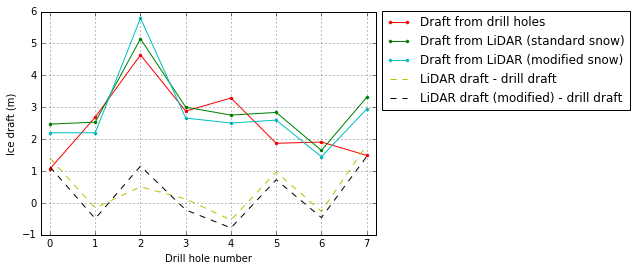

In [57]:
plt.plot(drill_draft, 'r.-', label='Draft from drill holes')
plt.plot(d_from_lidar, 'g.-', label='Draft from LiDAR (standard snow)')
plt.plot(d_from_lidar_mod, 'c.-', label='Draft from LiDAR (modified snow)')


plt.plot(np.array(d_from_lidar) - drill_draft, 'y--', label='LiDAR draft - drill draft')

plt.plot(np.array(d_from_lidar_mod) - drill_draft, 'k--', label='LiDAR draft (modified) - drill draft')

plt.xlim([-0.2, 7.2])
plt.legend(loc=2, bbox_to_anchor=(1,1.03))
plt.ylabel('Ice draft (m)')
plt.xlabel('Drill hole number')
plt.grid()

#plt.savefig('dist_drillholes_lidar_auv_draft.pdf', bbox_inches='tight')
#plt.savefig('dist_drillholes_lidar_auv_draft.png', bbox_inches='tight')

In [58]:
print('difference between drill hole and LiDAR draft: {}, sd: {}'.format(np.mean(drill_draft - d_from_lidar),
                                                                       np.std(drill_draft - d_from_lidar)))

difference between drill hole and LiDAR draft: -0.48330140058107546, sd: 0.7908934534728359


In [59]:
l_s = Estimation(lidar[this,1],lidar[this,2],zs_a_)
l_sa = Estimation(lidar[this,1],lidar[this,2],zs_a)

In [60]:
s_from_lidar = []
for hole in gtdrills:
    s_hole = l_s.estimate(hole[0], hole[1])
    s_from_lidar.append(s_hole)

sa_from_lidar = []
for hole in gtdrills:
    sa_hole = l_sa.estimate(hole[0], hole[1])
    sa_from_lidar.append(sa_hole)

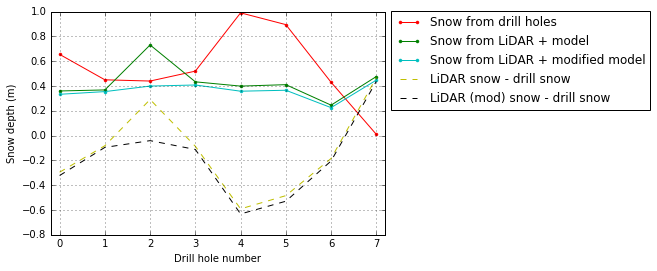

In [61]:
plt.plot(gtdrills[:,2], 'r.-', label='Snow from drill holes')
plt.plot(sa_from_lidar, 'g.-', label='Snow from LiDAR + model')
plt.plot(s_from_lidar, 'c.-', label='Snow from LiDAR + modified model')

plt.plot(np.array(sa_from_lidar) - gtdrills[:,2], 'y--', label='LiDAR snow - drill snow')
plt.plot(np.array(s_from_lidar) - gtdrills[:,2], 'k--', label='LiDAR (mod) snow - drill snow')


plt.xlim([-0.2, 7.2])
plt.legend(loc=2, bbox_to_anchor=(1,1.03))
plt.ylabel('Snow depth (m)')
plt.xlabel('Drill hole number')
plt.grid()

## Pulling it all together...

What does it look like at the transect if we plot:

- in situ ice thickness
- ice thickness with one snow measurement
- ice thickness with a modelled snow depth
- ice thickness with a modified snow model

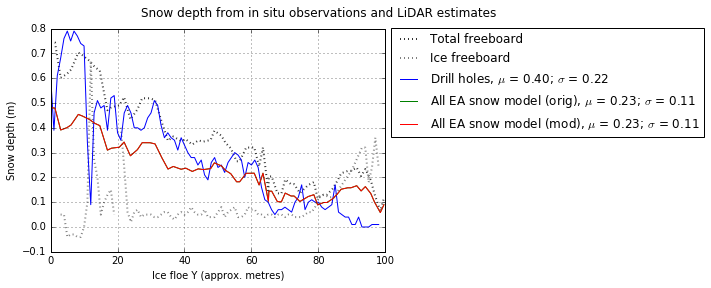

In [62]:
plt.plot(subset[lidar_ts[0],2], tf[lidar_ts[0]], linestyle = ':', linewidth='2', color='#333333', label="Total freeboard")

plt.plot(is6holes[1:100,1], is6fi[1:100], linestyle = ':', linewidth='2', color='gray', label="Ice freeboard")

plt.plot(is6holes[1:100,1], is6zs[1:100],
         label='Drill holes, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.nanmean(is6zs), np.nanstd(is6zs)))

plt.plot(lidar[lidar_t[0],2], zs_a[lidar_t[0]],
         label='All EA snow model (orig), $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.mean(zs_a[lidar_t[0]]),
                                                                            np.std(zs_a[lidar_t[0]])))

plt.plot(lidar[lidar_t[0],2], zs_a_[lidar_t[0]],
         label='All EA snow model (mod), $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.nanmean(zs_a_[lidar_t[0]]),
                                                                            np.nanstd(zs_a_[lidar_t[0]])))


plt.legend(loc=2, bbox_to_anchor=(1,1.03))

plt.grid()
plt.xlabel("Ice floe Y (approx. metres)")
plt.ylabel("Snow depth (m)")
plt.title('Snow depth from in situ observations and LiDAR estimates', y=1.03, x = 0.8)

plt.savefig('snow_depths_mod_snowmodel_is6_transect.pdf', bbox_inches='tight')

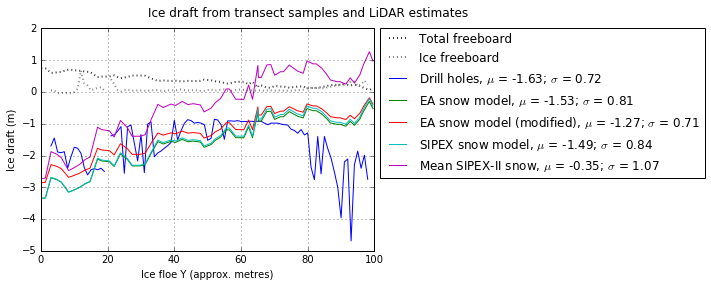

In [63]:
fig = plt.figure()
fig.set_size_inches(15/2.51, 10/2.51)

plt.plot(subset[lidar_ts[0],2], tf[lidar_ts[0]], linestyle = ':', linewidth='2', color='#333333', label="Total freeboard")

plt.plot(is6holes[1:100,1], is6fi[1:100], linestyle = ':', linewidth='2', color='gray', label="Ice freeboard")

plt.plot(is6holes[1:100,1], is6draft[1:100],
         label='Drill holes, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.nanmean(is6draft), np.nanstd(is6draft)))

plt.plot(subset[lidar_ts[0],2], df_s2snow[lidar_ts[0]],
         label='EA snow model, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.mean(df_s2snow[lidar_ts[0]]),
                                                                            np.std(df_s2snow[lidar_ts[0]])))

plt.plot(lidar[lidar_t[0],2], d_lm[lidar_t[0]],
         label='EA snow model (modified), $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.nanmean(d_lm[lidar_t[0]]),
                                                                            np.nanstd(d_lm[lidar_t[0]])))

plt.plot(subset[lidar_ts[0],2], df_sipex1snow[lidar_ts[0]],
         label='SIPEX snow model, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.nanmean(df_sipex1snow[lidar_ts[0]]),
                                                                            np.nanstd(df_sipex1snow[lidar_ts[0]])))

plt.plot(subset[lidar_ts[0],2], df_is6msnow[lidar_ts[0]],
         label='Mean SIPEX-II snow, $\mu$ = {0:.2f}; $\sigma$ = {1:.2f}'.format(np.nanmean(df_is6msnow[lidar_ts[0]]),
                                                                            np.nanstd(df_is6msnow[lidar_ts[0]])))

plt.legend(loc=2, bbox_to_anchor=(1,1.03))

plt.grid()
plt.xlabel("Ice floe Y (approx. metres)")
plt.ylabel("Ice draft (m)")
plt.title('Ice draft from transect samples and LiDAR estimates', y=1.03, x = 0.8)

plt.savefig('draft_strategies_mod_snowmodel_is6_transect.pdf', bbox_inches='tight')

NameError: name 'df_meansnow' is not defined

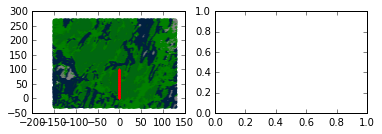

In [64]:
fig = plt.figure()
cmap= plt.get_cmap('ocean', 17)
cmap.set_under('gray')

fig.add_subplot()

ax0 = plt.subplot(2,2,1)
ax0.scatter(rsubset[:,1], rsubset[:,2], c=-df_s2r_snow + df_s2snow, cmap=cmap, lw=0, vmin=-1, vmax=8, s=10)

ax0.scatter(is6holes[:,0], is6holes[:,1], c='r', lw=0, s=3)

ax1 = plt.subplot(2,2,2)

ax1.scatter(rsubset[:,1], rsubset[:,2], c=df_s2snow-df_meansnow, cmap=cmap, lw=0, vmin=0, vmax=5, s=10)

ax1.scatter(is6holes[:,0], is6holes[:,1], c='r', lw=0, s=3)


plt.tight_layout()

In [ ]:
max(df_s2snow-df_meansnow)

## Putting all the density plots together

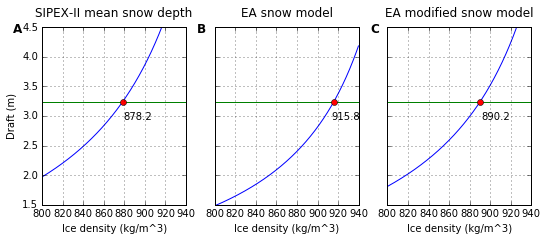

In [80]:
fig = plt.figure(figsize = ([22/2.51, 8/2.51]), dpi=300)

##sipex2 mean snow (0.27)
ax0 = fig.add_subplot(1,3,1)

ax0.plot(d_table_m[:,0], mean_draft_m, label='Mean LiDAR-derived draft')

ax0.plot(d_table_m[:,0], auv_mean, label='Mean AUV draft')

#idx_m = np.argwhere(np.isclose(auv_mean,mean_draft_m, atol=0.003)).reshape(-1)
ax0.plot(densities[idx_m], mean_draft_m[idx_m], 'ro')

ax0.text(densities[idx_m]+1, mean_draft_m[idx_m]-0.3, str(densities[idx_m]))

ax0.text(-0.17, 0.99,'A', ha='center', va='center', transform=ax0.transAxes, fontsize=12, weight='bold')

ax0.set_ylabel('Draft (m)')
ax0.set_xlabel('Ice density (kg/m^3)')
ax0.set_title('SIPEX-II mean snow depth', y=1.03)
ax0.grid()
ax0.set_ylim([1.5, 4.5])

#EA snow

ax1 = fig.add_subplot(1,3,2)

ax1.plot(d_table_[:,0], mean_draft_, label='Mean LiDAR-derived draft')

ax1.plot(d_table_[:,0], auv_mean, label='Mean AUV draft')

ax1.plot(densities[idx_], mean_draft_[idx_], 'ro')

ax1.text(densities[idx_]-2, mean_draft_[idx_]-0.3, str(densities[idx_]))

ax1.set_yticklabels([])
ax1.text(-0.09, 0.99,'B', ha='center', va='center', transform=ax1.transAxes, fontsize=12, weight='bold')

ax1.set_xlabel('Ice density (kg/m^3)')
ax1.set_title('EA snow model', y=1.03)
ax1.grid()
ax1.set_ylim([1.5, 4.5])

# all EA, modified

ax2 = fig.add_subplot(1,3,3)

ax2.plot(d_table_ts[:,0], mean_draft_ts, label='Mean LiDAR-derived draft')

ax2.plot(d_table_ts[:,0], auv_mean, label='Mean AUV draft')

ax2.plot(densities[idx_ts], mean_draft_ts[idx_ts], 'ro')

ax2.text(densities[idx_ts]+1, mean_draft_ts[idx_ts]-0.3, str(densities[idx_ts]))

ax2.set_yticklabels([])

ax2.text(-0.09, 0.99,'C', ha='center', va='center', transform=ax2.transAxes, fontsize=12, weight='bold')

ax2.set_xlabel('Ice density (kg/m^3)')
ax2.set_title('EA modified snow model', y=1.03)
ax2.grid()
ax2.set_ylim([1.5, 4.5])

fig.subplots_adjust(wspace=0.2)

plt.savefig('ch5_density_finding_comparision.pdf', bbox_inches='tight')
